In [7]:
import pandas as pd
import json
import csv
import json
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuan2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Read data

### jobtitle

# Read the TF-IDF values from the CSV file
jobtitle_tfidf_df = pd.read_csv('jobtitle_tfidf.csv', index_col=0)
# Read the job title dictionary for tie-breaking
with open('jobtitle_dictionary.json', 'r') as file:
    jobtitle_dict = json.load(file)
# Read the index table to map back to original job titles
index_table_jobtitle = pd.read_csv('indexTable_jobtitle.csv')


### jobline

# Read the TF-IDF values from the CSV file
jobline_tfidf_df = pd.read_csv('jobline_tfidf.csv', index_col=0)
# Read the job line dictionary for tie-breaking
with open('jobline_dictionary.json', 'r') as file:
    joblines_dict = json.load(file)

# Load the JSON file mapping job titles to job lines
with open('jobtitle_jobline_pairs_merged.json', 'r', encoding='utf-8') as file:
    jobtitle_jobline_pairs = json.load(file)

    
# Read the index table to map back to original job titles
index_table_jobline = pd.read_csv('indexTable_jobline.csv')

In [15]:
# 前處理
def Preprocessing(job):
    # 只留下英文字
    job = re.sub('/', ' ',job)

    job = re.sub('[^a-zA-Z]', ' ',job)
    job = re.sub(r'\b[a-zA-Z]\b', ' ',job)
    # 將IT轉為Information Technology
    job = re.sub(r"IT ", "Information Technology ",job)

    # 將所有英文字元都轉為小寫
    job = job.lower()
    # 把文章前後的空白刪掉
    job = job.strip()
    # 移除stopwords
    stop_words = set(stopwords.words('english'))
    job = ' '.join([word for word in job.split() if word not in stop_words])

    # 把有連續>=2個white space的地方改成一格就好
    job = re.sub(' +', ' ', job)
    # 用Porter’s algorithm 來進行Stemming
    ps = PorterStemmer()
    job = ' '.join([ps.stem(token) for token in job.split()])

    return job

def generate_wordcloud(data):
    # Join all job titles into a single string
    text = ' '.join(data)

    # Check if there is text to generate a word cloud
    if not text.strip():
        print("No data available to generate a word cloud.")
        return

    # Create a WordCloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)

    # Display the generated WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()


# Job title recommendation function
def jobtitle_recommendation(processed_query):

    # Assuming space-separated terms
    query_terms = processed_query.split()

    # Filter out terms that are not in the TF-IDF dataframe columns
    valid_terms = [term for term in query_terms if term in jobtitle_tfidf_df.columns]

    # Calculate the score for each document (job title) only with valid terms
    if valid_terms:  # Ensure there are valid terms to avoid KeyError
        scores = jobtitle_tfidf_df[valid_terms].sum(axis=1)
    else:
        print("No matching terms found in the TF-IDF data.")
        return

    # Sort the scores and select top 5, breaking ties using the dictionary and alphabetically
    top_jobtitles = scores.sort_values(ascending=False).head(5)
    top_jobtitles = top_jobtitles.index.tolist()
    # Resolve ties
    top_jobtitles.sort(key=lambda x: (-scores[x], -jobtitle_dict.get(x, 0), x))

    original_titles = index_table_jobtitle.loc[index_table_jobtitle['Index'].isin(top_jobtitles)]['JobTitle'].tolist()
    # Present Options to User
    print("Top job titles matching your query:")
    i = 1
    for title in original_titles:
        print(i, title)
        i += 1

    return original_titles

# Job line recommendation function
def jobline_recommendation(processed_query):

    # Assuming space-separated terms
    query_terms = processed_query.split()

    # Filter out terms that are not in the TF-IDF dataframe columns
    valid_terms = [term for term in query_terms if term in jobline_tfidf_df .columns]

    # Calculate the score for each document (job title) only with valid terms
    if valid_terms:  # Ensure there are valid terms to avoid KeyError
        scores = jobline_tfidf_df [valid_terms].sum(axis=1)
    else:
        print("No matching terms found in the TF-IDF data.")
        print(query_terms)
        return

    # Sort the scores and select top 20, breaking ties using the dictionary and alphabetically
    top_joblines = scores.sort_values(ascending=False).head(20)
    top_joblines = top_joblines.index.tolist()
    # Resolve ties
    top_joblines.sort(key=lambda x: (-scores[x], -joblines_dict.get(x, 0), x))

    # original_lines = []
    original_lines = index_table_jobline.loc[top_joblines]["JobLine"].tolist()

    # Filter job lines that have at least five characters
    original_lines = [line for line in original_lines if len(line.split()) > 5]

    # Present top 5 Options to User
    print("Top job lines matching your query:")
    i = 1
    printed_line = []
    for line in original_lines:
        line = line.replace('\n', ' ')
        line = re.sub(' +', ' ', line)
        if i > 5:
            break
        if (line in printed_line): # to avoid duplicates
            continue
        else:
          print(i, line)
          i += 1
          printed_line.append(line)

    return top_joblines


Top job titles matching your query:
1 Software Engineer
2 Software Engineering Manager
3 Software Development Engineer
4 Software Engineer Developer
5 Software Engineering and Management


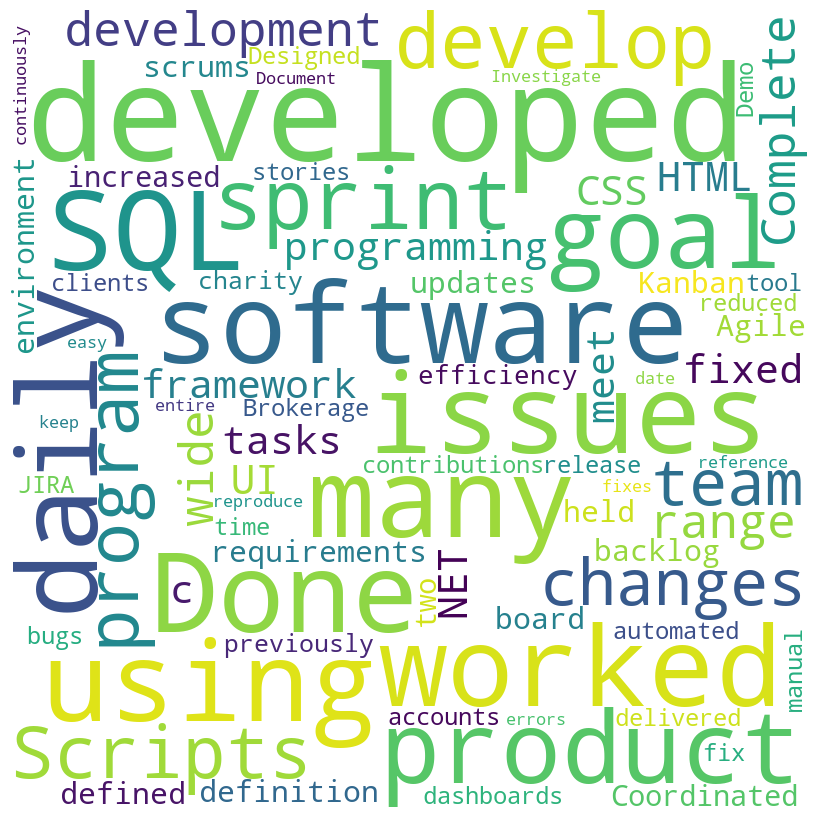


Top job lines matching your query:
1 Developed requirements for new application software.
2 Develop in Python/C/C++ or other applicable technologies
3 As Director of Software Development Group (2006): Oversaw development process for three teams (15 developers).
4 Conducted full life-cycle software development in multiple software environments.
5 Managed and led multiple software development teams.


In [27]:
# the main function
if __name__ == "__main__":
    # User Input
    user_input1 = input("Please enter your job title: ")
    print("")
    processed_query1 = Preprocessing(user_input1)
    # job title recomendation
    output1 = jobtitle_recommendation(processed_query1)

    user_select1 = input("\nPlease choose your choice(1-5): ")
    selected_jobtitle = output1[int(user_select1) - 1]

    job_lines = jobtitle_jobline_pairs.get(selected_jobtitle, [])
    # Process job lines and skip empty results
    processed_job_lines = [line for line in job_lines.values()]

    generate_wordcloud(processed_job_lines)

    # Continue with job line recommendation
    user_input2 = input("\nPlease enter your job line keywords: ")
    user_input2 = user_input2 + " " + selected_jobtitle
    print("")

    processed_query2 = Preprocessing(user_input2)
    jobline_recommendation(processed_query2)
